# Figure 2 (Molina et al., submitted)

Figure 2. Duration (in days) of each initial (i.e., first) weather regime for all CESM2 initialized reforecasts (October–March, 1999-2019). The blue bars show the CESM2 11-member ensemble mean and the error bars indicate 11-member ensemble spread. ERA5 weather regime duration is also indicated for reference (black bars). Weeks 3-4 indicated with gray shading.

## Imports

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics

import som_analysis
import cluster_analysis
import narm_analysis

## functions

In [2]:
def get_cold_indx(ds, mo_init=9, mo_end=2):
    """
    Extract indices for cold season.
    Grabbing Sept thru February init, for Oct thru March predictions.
    """
    dt_array = pd.to_datetime(ds['time'])
    return xr.where((dt_array.month >= mo_init) | (
        dt_array.month <= mo_end), True, False)

In [3]:
def hist_ensembles(cluster_file_evo, ensemble_member):

    thearray = cluster_file_evo

    wr1_file = []
    wr2_file = []
    wr3_file = []
    wr4_file = []

    # number of forecasts
    for i in range(543):

        for j in range(43):

            if j == 0:

                wr_ = thearray[ensemble_member, i, j]
                wr_count = 1

            if j > 0:

                if wr_ == thearray[ensemble_member, i, j]:
                    wr_count += 1

                if wr_ != thearray[ensemble_member, i, j]:

                    if wr_ == 0.0:
                        wr1_file.append(wr_count)
                    if wr_ == 1.0:
                        wr2_file.append(wr_count)
                    if wr_ == 2.0:
                        wr3_file.append(wr_count)
                    if wr_ == 3.0:
                        wr4_file.append(wr_count)
                    break

    wr1_file = np.array(wr1_file)
    wr2_file = np.array(wr2_file)
    wr3_file = np.array(wr3_file)
    wr4_file = np.array(wr4_file)

    wr1_file_frq, wr1_file_bns, _ = plt.hist(wr1_file, bins=wr1_file.max() - 1)
    plt.close()
    wr2_file_frq, wr2_file_bns, _ = plt.hist(wr2_file, bins=wr2_file.max() - 1)
    plt.close()
    wr3_file_frq, wr3_file_bns, _ = plt.hist(wr3_file, bins=wr3_file.max() - 1)
    plt.close()
    wr4_file_frq, wr4_file_bns, _ = plt.hist(wr4_file, bins=wr4_file.max() - 1)
    plt.close()

    return wr1_file_frq, wr1_file_bns, wr2_file_frq, wr2_file_bns, wr3_file_frq, wr3_file_bns, wr4_file_frq, wr4_file_bns

In [4]:
def gap_fill_hist(frq_array, bns_array, max_bins):

    list_bns = []
    list_frq = []

    for indx, i in enumerate((max_bins + 0.5)[:-1]):

        if np.isin(i, (bns_array + 0.5)[:-1]):

            list_bns.append((bns_array + 0.5)[:-1][indx])
            list_frq.append((frq_array)[indx])

        if not np.isin(i, (bns_array + 0.5)[:-1]):

            list_bns.append(i)
            list_frq.append(0.0)

    return np.array(list_frq), np.array(list_bns)

## open and preprocess data

In [5]:
# region for clustering
lat0 = 10
lat1 = 70
lon0 = -150
lon1 = -40

# open era5 data and slice
ds_era5 = narm_analysis.era5_z500(
    lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1)

# era5 anomalies
ds_era5_anom = narm_analysis.era5_climo_wrs(
    ds_era5, rolling_days=5, variable='clim')

# restructure era5 array for machine learning training (SONDJFM)
ds_era5_anom = ds_era5_anom[
    get_cold_indx(ds_era5_anom, mo_init=10, mo_end=3), ...]
ds_era5_train = ds_era5_anom.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values

## pca and kmeans with era5

In [6]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(ds_era5_train)

# transform era5 data with pca
ds_era5_train = pca_obj.transform(ds_era5_train)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(
f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}'
)

Variance explained: [25.95315607 17.65410568 11.94871708  9.0784389   7.98100848  6.14181738
  4.32605934  2.61658689  2.22642929  2.17049559  1.49813958  1.22541708]
Cumulative sum of variance explained for EOF1 and EOF2: [25.95315607 43.60726175 55.55597883 64.63441774 72.61542622 78.7572436
 83.08330294 85.69988983 87.92631912 90.09681471 91.59495429 92.82037136]


In [7]:
# train kmeans
k_means = KMeans(n_clusters=4,
                 init='k-means++',
                 n_init=10000,
                 max_iter=300,
                 tol=0.0001,
                 verbose=0,
                 random_state=0).fit(ds_era5_train)

print(f'inertia: {k_means.inertia_}')

inertia: 39379.20526778629


## load data with lead time bias corrected anomalies

In [8]:
# era5 data
z500_era5, z500_era5_dt = som_analysis.open_era5_files(
    variable='z500', return_time=True,
    lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1,
    leadday0=0, leadday1=42, rolldays=5,)

# cesm data
z500_cesm, z500_cesm_dt = som_analysis.open_cesm_files(
    variable='zg_500', return_time=True,
    lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1,
    leadday0=0, leadday1=42, rolldays=5,)

# cesm ensemble data
z500_ensm, z500_ensm_dt, z_ensm = som_analysis.open_cesm_ensembles(
    variable='zg_500', return_time=True,
    lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1,
    leadday0=0, leadday1=42, return_ens=True, rolldays=5)

# restructure arrays
z500_standard_era5 = z500_era5.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')
z500_standard_cesm = z500_cesm.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')
z500_standard_ensm = z500_ensm.stack(
    new=('time', 'ensemble', 'lead'),
    flat=('lat', 'lon')).transpose('new', 'flat')

## extract cluster labels

(projecting era5 pca and kmeans onto cesm2)

In [9]:
cluster_era5_evo = cluster_analysis.single_clusters(
    z500_standard_era5, k_means, pca_obj, use_pca=True)
cluster_cesm_evo = cluster_analysis.single_clusters(
    z500_standard_cesm, k_means, pca_obj, use_pca=True)
cluster_ensm_evo = cluster_analysis.ensemble_clusters(
    z500_standard_ensm, k_means, pca_obj, use_pca=True)

In [10]:
# 1) if you start in one regime -- is it mostly guaranteed that you will
# be in another regime by weeks 3-4, 5-6? (mean duration until weather regime change)?
# 2) what is the average duration of each weather regime when started?
# what is the max/min duration? mean duration in general (any lead time)?

In [11]:
wr1_era5_frq, wr1_era5_bns, wr2_era5_frq, wr2_era5_bns, wr3_era5_frq, wr3_era5_bns, wr4_era5_frq, wr4_era5_bns = hist_ensembles(
    cluster_era5_evo, 0)

In [12]:
wr1_cesm_frq, wr1_cesm_bns, wr2_cesm_frq, wr2_cesm_bns, wr3_cesm_frq, wr3_cesm_bns, wr4_cesm_frq, wr4_cesm_bns = hist_ensembles(
    cluster_cesm_evo, 0)

In [13]:
wr1_ce00_frq, wr1_ce00_bns, wr2_ce00_frq, wr2_ce00_bns, wr3_ce00_frq, wr3_ce00_bns, wr4_ce00_frq, wr4_ce00_bns = hist_ensembles(
    cluster_ensm_evo, 0)
wr1_ce01_frq, wr1_ce01_bns, wr2_ce01_frq, wr2_ce01_bns, wr3_ce01_frq, wr3_ce01_bns, wr4_ce01_frq, wr4_ce01_bns = hist_ensembles(
    cluster_ensm_evo, 1)
wr1_ce02_frq, wr1_ce02_bns, wr2_ce02_frq, wr2_ce02_bns, wr3_ce02_frq, wr3_ce02_bns, wr4_ce02_frq, wr4_ce02_bns = hist_ensembles(
    cluster_ensm_evo, 2)
wr1_ce03_frq, wr1_ce03_bns, wr2_ce03_frq, wr2_ce03_bns, wr3_ce03_frq, wr3_ce03_bns, wr4_ce03_frq, wr4_ce03_bns = hist_ensembles(
    cluster_ensm_evo, 3)
wr1_ce04_frq, wr1_ce04_bns, wr2_ce04_frq, wr2_ce04_bns, wr3_ce04_frq, wr3_ce04_bns, wr4_ce04_frq, wr4_ce04_bns = hist_ensembles(
    cluster_ensm_evo, 4)
wr1_ce05_frq, wr1_ce05_bns, wr2_ce05_frq, wr2_ce05_bns, wr3_ce05_frq, wr3_ce05_bns, wr4_ce05_frq, wr4_ce05_bns = hist_ensembles(
    cluster_ensm_evo, 5)
wr1_ce06_frq, wr1_ce06_bns, wr2_ce06_frq, wr2_ce06_bns, wr3_ce06_frq, wr3_ce06_bns, wr4_ce06_frq, wr4_ce06_bns = hist_ensembles(
    cluster_ensm_evo, 6)
wr1_ce07_frq, wr1_ce07_bns, wr2_ce07_frq, wr2_ce07_bns, wr3_ce07_frq, wr3_ce07_bns, wr4_ce07_frq, wr4_ce07_bns = hist_ensembles(
    cluster_ensm_evo, 7)
wr1_ce08_frq, wr1_ce08_bns, wr2_ce08_frq, wr2_ce08_bns, wr3_ce08_frq, wr3_ce08_bns, wr4_ce08_frq, wr4_ce08_bns = hist_ensembles(
    cluster_ensm_evo, 8)
wr1_ce09_frq, wr1_ce09_bns, wr2_ce09_frq, wr2_ce09_bns, wr3_ce09_frq, wr3_ce09_bns, wr4_ce09_frq, wr4_ce09_bns = hist_ensembles(
    cluster_ensm_evo, 9)
wr1_ce10_frq, wr1_ce10_bns, wr2_ce10_frq, wr2_ce10_bns, wr3_ce10_frq, wr3_ce10_bns, wr4_ce10_frq, wr4_ce10_bns = hist_ensembles(
    cluster_ensm_evo, 10)

In [14]:
wr1era5_frq, wr1era5_bns = gap_fill_hist(wr1_era5_frq, wr1_era5_bns, wr4_cesm_bns)
wr2era5_frq, wr2era5_bns = gap_fill_hist(wr2_era5_frq, wr2_era5_bns, wr4_cesm_bns)
wr3era5_frq, wr3era5_bns = gap_fill_hist(wr3_era5_frq, wr3_era5_bns, wr4_cesm_bns)
wr4era5_frq, wr4era5_bns = gap_fill_hist(wr4_era5_frq, wr4_era5_bns, wr4_cesm_bns)

wr1cesm_frq, wr1cesm_bns = gap_fill_hist(wr1_cesm_frq, wr1_cesm_bns, wr4_cesm_bns)
wr2cesm_frq, wr2cesm_bns = gap_fill_hist(wr2_cesm_frq, wr2_cesm_bns, wr4_cesm_bns)
wr3cesm_frq, wr3cesm_bns = gap_fill_hist(wr3_cesm_frq, wr3_cesm_bns, wr4_cesm_bns)
wr4cesm_frq, wr4cesm_bns = gap_fill_hist(wr4_cesm_frq, wr4_cesm_bns, wr4_cesm_bns)

wr1ce00_frq, wr1ce00_bns = gap_fill_hist(wr1_ce00_frq, wr1_ce00_bns, wr4_cesm_bns)
wr2ce00_frq, wr2ce00_bns = gap_fill_hist(wr2_ce00_frq, wr2_ce00_bns, wr4_cesm_bns)
wr3ce00_frq, wr3ce00_bns = gap_fill_hist(wr3_ce00_frq, wr3_ce00_bns, wr4_cesm_bns)
wr4ce00_frq, wr4ce00_bns = gap_fill_hist(wr4_ce00_frq, wr4_ce00_bns, wr4_cesm_bns)

wr1ce01_frq, wr1ce01_bns = gap_fill_hist(wr1_ce01_frq, wr1_ce01_bns, wr4_cesm_bns)
wr2ce01_frq, wr2ce01_bns = gap_fill_hist(wr2_ce01_frq, wr2_ce01_bns, wr4_cesm_bns)
wr3ce01_frq, wr3ce01_bns = gap_fill_hist(wr3_ce01_frq, wr3_ce01_bns, wr4_cesm_bns)
wr4ce01_frq, wr4ce01_bns = gap_fill_hist(wr4_ce01_frq, wr4_ce01_bns, wr4_cesm_bns)

wr1ce02_frq, wr1ce02_bns = gap_fill_hist(wr1_ce02_frq, wr1_ce02_bns, wr4_cesm_bns)
wr2ce02_frq, wr2ce02_bns = gap_fill_hist(wr2_ce02_frq, wr2_ce02_bns, wr4_cesm_bns)
wr3ce02_frq, wr3ce02_bns = gap_fill_hist(wr3_ce02_frq, wr3_ce02_bns, wr4_cesm_bns)
wr4ce02_frq, wr4ce02_bns = gap_fill_hist(wr4_ce02_frq, wr4_ce02_bns, wr4_cesm_bns)

wr1ce03_frq, wr1ce03_bns = gap_fill_hist(wr1_ce03_frq, wr1_ce03_bns, wr4_cesm_bns)
wr2ce03_frq, wr2ce03_bns = gap_fill_hist(wr2_ce03_frq, wr2_ce03_bns, wr4_cesm_bns)
wr3ce03_frq, wr3ce03_bns = gap_fill_hist(wr3_ce03_frq, wr3_ce03_bns, wr4_cesm_bns)
wr4ce03_frq, wr4ce03_bns = gap_fill_hist(wr4_ce03_frq, wr4_ce03_bns, wr4_cesm_bns)

wr1ce04_frq, wr1ce04_bns = gap_fill_hist(wr1_ce04_frq, wr1_ce04_bns, wr4_cesm_bns)
wr2ce04_frq, wr2ce04_bns = gap_fill_hist(wr2_ce04_frq, wr2_ce04_bns, wr4_cesm_bns)
wr3ce04_frq, wr3ce04_bns = gap_fill_hist(wr3_ce04_frq, wr3_ce04_bns, wr4_cesm_bns)
wr4ce04_frq, wr4ce04_bns = gap_fill_hist(wr4_ce04_frq, wr4_ce04_bns, wr4_cesm_bns)

wr1ce05_frq, wr1ce05_bns = gap_fill_hist(wr1_ce05_frq, wr1_ce05_bns, wr4_cesm_bns)
wr2ce05_frq, wr2ce05_bns = gap_fill_hist(wr2_ce05_frq, wr2_ce05_bns, wr4_cesm_bns)
wr3ce05_frq, wr3ce05_bns = gap_fill_hist(wr3_ce05_frq, wr3_ce05_bns, wr4_cesm_bns)
wr4ce05_frq, wr4ce05_bns = gap_fill_hist(wr4_ce05_frq, wr4_ce05_bns, wr4_cesm_bns)

wr1ce06_frq, wr1ce06_bns = gap_fill_hist(wr1_ce06_frq, wr1_ce06_bns, wr4_cesm_bns)
wr2ce06_frq, wr2ce06_bns = gap_fill_hist(wr2_ce06_frq, wr2_ce06_bns, wr4_cesm_bns)
wr3ce06_frq, wr3ce06_bns = gap_fill_hist(wr3_ce06_frq, wr3_ce06_bns, wr4_cesm_bns)
wr4ce06_frq, wr4ce06_bns = gap_fill_hist(wr4_ce06_frq, wr4_ce06_bns, wr4_cesm_bns)

wr1ce07_frq, wr1ce07_bns = gap_fill_hist(wr1_ce07_frq, wr1_ce07_bns, wr4_cesm_bns)
wr2ce07_frq, wr2ce07_bns = gap_fill_hist(wr2_ce07_frq, wr2_ce07_bns, wr4_cesm_bns)
wr3ce07_frq, wr3ce07_bns = gap_fill_hist(wr3_ce07_frq, wr3_ce07_bns, wr4_cesm_bns)
wr4ce07_frq, wr4ce07_bns = gap_fill_hist(wr4_ce07_frq, wr4_ce07_bns, wr4_cesm_bns)

wr1ce08_frq, wr1ce08_bns = gap_fill_hist(wr1_ce08_frq, wr1_ce08_bns, wr4_cesm_bns)
wr2ce08_frq, wr2ce08_bns = gap_fill_hist(wr2_ce08_frq, wr2_ce08_bns, wr4_cesm_bns)
wr3ce08_frq, wr3ce08_bns = gap_fill_hist(wr3_ce08_frq, wr3_ce08_bns, wr4_cesm_bns)
wr4ce08_frq, wr4ce08_bns = gap_fill_hist(wr4_ce08_frq, wr4_ce08_bns, wr4_cesm_bns)

wr1ce09_frq, wr1ce09_bns = gap_fill_hist(wr1_ce09_frq, wr1_ce09_bns, wr4_cesm_bns)
wr2ce09_frq, wr2ce09_bns = gap_fill_hist(wr2_ce09_frq, wr2_ce09_bns, wr4_cesm_bns)
wr3ce09_frq, wr3ce09_bns = gap_fill_hist(wr3_ce09_frq, wr3_ce09_bns, wr4_cesm_bns)
wr4ce09_frq, wr4ce09_bns = gap_fill_hist(wr4_ce09_frq, wr4_ce09_bns, wr4_cesm_bns)

wr1ce10_frq, wr1ce10_bns = gap_fill_hist(wr1_ce10_frq, wr1_ce10_bns, wr4_cesm_bns)
wr2ce10_frq, wr2ce10_bns = gap_fill_hist(wr2_ce10_frq, wr2_ce10_bns, wr4_cesm_bns)
wr3ce10_frq, wr3ce10_bns = gap_fill_hist(wr3_ce10_frq, wr3_ce10_bns, wr4_cesm_bns)
wr4ce10_frq, wr4ce10_bns = gap_fill_hist(wr4_ce10_frq, wr4_ce10_bns, wr4_cesm_bns)

In [15]:
wr1ensm_frq = np.stack([
                    wr1ce00_frq,
                    wr1ce01_frq,
                    wr1ce02_frq,
                    wr1ce03_frq,
                    wr1ce04_frq,
                    wr1ce05_frq,
                    wr1ce06_frq,
                    wr1ce07_frq,
                    wr1ce08_frq,
                    wr1ce09_frq,
                    wr1ce10_frq
                ])

wr2ensm_frq = np.stack([
                    wr2ce00_frq,
                    wr2ce01_frq,
                    wr2ce02_frq,
                    wr2ce03_frq,
                    wr2ce04_frq,
                    wr2ce05_frq,
                    wr2ce06_frq,
                    wr2ce07_frq,
                    wr2ce08_frq,
                    wr2ce09_frq,
                    wr2ce10_frq
                ])

wr3ensm_frq = np.stack([
                    wr3ce00_frq,
                    wr3ce01_frq,
                    wr3ce02_frq,
                    wr3ce03_frq,
                    wr3ce04_frq,
                    wr3ce05_frq,
                    wr3ce06_frq,
                    wr3ce07_frq,
                    wr3ce08_frq,
                    wr3ce09_frq,
                    wr3ce10_frq
                ])

wr4ensm_frq = np.stack([
                    wr4ce00_frq,
                    wr4ce01_frq,
                    wr4ce02_frq,
                    wr4ce03_frq,
                    wr4ce04_frq,
                    wr4ce05_frq,
                    wr4ce06_frq,
                    wr4ce07_frq,
                    wr4ce08_frq,
                    wr4ce09_frq,
                    wr4ce10_frq
                ])

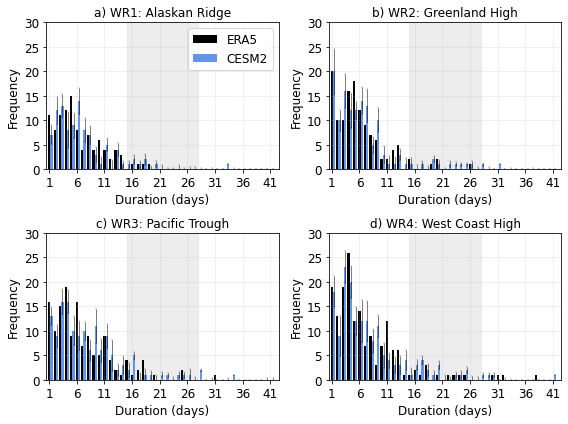

In [16]:
# --

fig, axs = plt.subplots(2, 2, subplot_kw=dict(), figsize=(8, 6))

b1 = axs[0][0].bar(wr1era5_bns - 0.5, wr1era5_frq, width=0.4, color='k', zorder=10)
b2 = axs[0][0].bar(wr1cesm_bns - 0.1, wr1cesm_frq, width=0.4,
                   yerr=np.nanstd(wr1ensm_frq, axis=0), color='cornflowerblue',
                   error_kw=dict(lw=0.5, capsize=1.0, capthick=0.25), zorder=10)

axs[0][0].legend([b1, b2], ['ERA5', 'CESM2'], fontsize=12,
                 fancybox=True)

axs[0][0].margins(x=0, y=0)
axs[0][0].grid(alpha=0.5, lw=0.5, ls='--')

axs[0][0].set_xlim([0.5, 42.5])
axs[0][0].set_ylim([0, 30])

axs[0][0].set_xticks(list(np.arange(0, 42, 1))[1::5])
axs[0][0].set_xticklabels(list(np.arange(0, 42, 1))[1::5], fontsize=12)
axs[0][0].set_xlabel('Duration (days)', fontsize=12)

axs[0][0].set_yticks(list(np.arange(0, 31, 1))[::5])
axs[0][0].set_yticklabels(list(np.arange(0, 31, 1))[::5], fontsize=12)
axs[0][0].set_ylabel('Frequency', fontsize=12)

axs[0][0].set_title('a) WR1: Alaskan Ridge', fontsize=12)

axs[0][0].fill_between(
    (wr1era5_bns-0.5)[14:28], 0, 30, zorder=0, color='gainsboro', alpha=0.5)

# --

axs[0][1].bar(wr2era5_bns - 0.5, wr2era5_frq, width=0.4, color='k')
axs[0][1].bar(wr2cesm_bns - 0.1, wr2cesm_frq, width=0.4,
              yerr=np.nanstd(wr2ensm_frq, axis=0), color='cornflowerblue',
              error_kw=dict(lw=0.5, capsize=1.0, capthick=0.25))

axs[0][1].margins(x=0, y=0)
axs[0][1].grid(alpha=0.5, lw=0.5, ls='--')

axs[0][1].set_xlim([0.5, 42.5])
axs[0][1].set_ylim([0, 30])

axs[0][1].set_xticks(list(np.arange(0, 42, 1))[1::5])
axs[0][1].set_xticklabels(list(np.arange(0, 42, 1))[1::5], fontsize=12)
axs[0][1].set_xlabel('Duration (days)', fontsize=12)

axs[0][1].set_yticks(list(np.arange(0, 31, 1))[::5])
axs[0][1].set_yticklabels(list(np.arange(0, 31, 1))[::5], fontsize=12)
axs[0][1].set_ylabel('Frequency', fontsize=12)

axs[0][1].set_title('b) WR2: Greenland High', fontsize=12)

axs[0][1].fill_between(
    (wr1era5_bns-0.5)[14:28], 0, 30, zorder=0, color='gainsboro', alpha=0.5)

# --

axs[1][0].bar(wr3era5_bns - 0.5, wr3era5_frq, width=0.4, color='k')
axs[1][0].bar(wr3cesm_bns - 0.1, wr3cesm_frq, width=0.4,
              yerr=np.nanstd(wr3ensm_frq, axis=0), color='cornflowerblue',
              error_kw=dict(lw=0.5, capsize=1.0, capthick=0.25))

axs[1][0].grid(alpha=0.5, lw=0.5, ls='--')
axs[1][0].margins(x=0, y=0)

axs[1][0].set_xlim([0.5, 42.5])
axs[1][0].set_ylim([0, 30])

axs[1][0].set_xticks(list(np.arange(0, 42, 1))[1::5])
axs[1][0].set_xticklabels(list(np.arange(0, 42, 1))[1::5], fontsize=12)
axs[1][0].set_xlabel('Duration (days)', fontsize=12)

axs[1][0].set_yticks(list(np.arange(0, 31, 1))[::5])
axs[1][0].set_yticklabels(list(np.arange(0, 31, 1))[::5], fontsize=12)
axs[1][0].set_ylabel('Frequency', fontsize=12)

axs[1][0].set_title('c) WR3: Pacific Trough', fontsize=12)

axs[1][0].fill_between(
    (wr1era5_bns-0.5)[14:28], 0, 30, zorder=0, color='gainsboro', alpha=0.5)

# --

axs[1][1].bar(wr4era5_bns - 0.5, wr4era5_frq, width=0.4, color='k')
axs[1][1].bar(wr4cesm_bns - 0.1, wr4cesm_frq, width=0.4,
              yerr=np.nanstd(wr4ensm_frq, axis=0), color='cornflowerblue',
              error_kw=dict(lw=0.5, capsize=1.0, capthick=0.25))

axs[1][1].grid(alpha=0.5, lw=0.5, ls='--')
axs[1][1].margins(x=0, y=0)

axs[1][1].set_xlim([0.5, 42.5])
axs[1][1].set_ylim([0, 30])

axs[1][1].set_xticks(list(np.arange(0, 42, 1))[1::5])
axs[1][1].set_xticklabels(list(np.arange(0, 42, 1))[1::5], fontsize=12)
axs[1][1].set_xlabel('Duration (days)', fontsize=12)

axs[1][1].set_yticks(list(np.arange(0, 31, 1))[::5])
axs[1][1].set_yticklabels(list(np.arange(0, 31, 1))[::5], fontsize=12)
axs[1][1].set_ylabel('Frequency', fontsize=12)

axs[1][1].set_title('d) WR4: West Coast High', fontsize=12)

axs[1][1].fill_between(
    (wr1era5_bns-0.5)[14:28], 0, 30, zorder=0, color='gainsboro', alpha=0.5)

# --

plt.tight_layout()
plt.savefig("fig_frequency_wrs.png", bbox_inches='tight', dpi=500)
plt.show()

# --

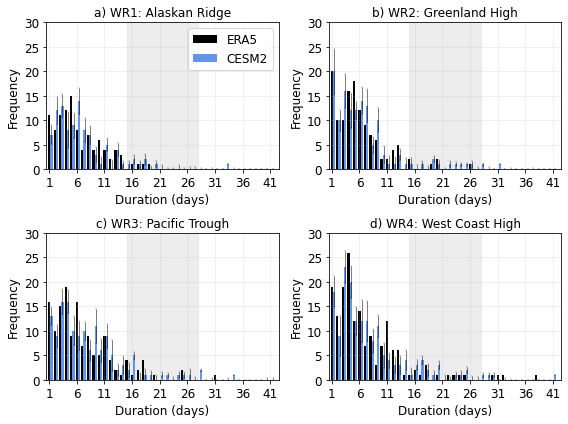

In [17]:
# --

fig, axs = plt.subplots(2, 2, subplot_kw=dict(), figsize=(8, 6))

b1 = axs[0][0].bar(wr1era5_bns - 0.5, wr1era5_frq, width=0.4, color='k', zorder=10)
b2 = axs[0][0].bar(wr1cesm_bns - 0.1, wr1cesm_frq, width=0.4,
                   yerr=np.nanstd(wr1ensm_frq, axis=0), color='cornflowerblue',
                   error_kw=dict(lw=0.5, capsize=1.0, capthick=0.25), zorder=10)

axs[0][0].legend([b1, b2], ['ERA5', 'CESM2'], fontsize=12,
                 fancybox=True)

axs[0][0].margins(x=0, y=0)
axs[0][0].grid(alpha=0.5, lw=0.5, ls='--')

axs[0][0].set_xlim([0.5, 42.5])
axs[0][0].set_ylim([0, 30])

axs[0][0].set_xticks(list(np.arange(0, 42, 1))[1::5])
axs[0][0].set_xticklabels(list(np.arange(0, 42, 1))[1::5], fontsize=12)
axs[0][0].set_xlabel('Duration (days)', fontsize=12)

axs[0][0].set_yticks(list(np.arange(0, 31, 1))[::5])
axs[0][0].set_yticklabels(list(np.arange(0, 31, 1))[::5], fontsize=12)
axs[0][0].set_ylabel('Frequency', fontsize=12)

axs[0][0].set_title('a) WR1: Alaskan Ridge', fontsize=12)

axs[0][0].fill_between(
    (wr1era5_bns-0.5)[14:28], 0, 30, zorder=0, color='gainsboro', alpha=0.5)

# --

axs[0][1].bar(wr2era5_bns - 0.5, wr2era5_frq, width=0.4, color='k')
axs[0][1].bar(wr2cesm_bns - 0.1, wr2cesm_frq, width=0.4,
              yerr=np.nanstd(wr2ensm_frq, axis=0), color='cornflowerblue',
              error_kw=dict(lw=0.5, capsize=1.0, capthick=0.25))

axs[0][1].margins(x=0, y=0)
axs[0][1].grid(alpha=0.5, lw=0.5, ls='--')

axs[0][1].set_xlim([0.5, 42.5])
axs[0][1].set_ylim([0, 30])

axs[0][1].set_xticks(list(np.arange(0, 42, 1))[1::5])
axs[0][1].set_xticklabels(list(np.arange(0, 42, 1))[1::5], fontsize=12)
axs[0][1].set_xlabel('Duration (days)', fontsize=12)

axs[0][1].set_yticks(list(np.arange(0, 31, 1))[::5])
axs[0][1].set_yticklabels(list(np.arange(0, 31, 1))[::5], fontsize=12)
axs[0][1].set_ylabel('Frequency', fontsize=12)

axs[0][1].set_title('b) WR2: Greenland High', fontsize=12)

axs[0][1].fill_between(
    (wr1era5_bns-0.5)[14:28], 0, 30, zorder=0, color='gainsboro', alpha=0.5)

# --

axs[1][0].bar(wr3era5_bns - 0.5, wr3era5_frq, width=0.4, color='k')
axs[1][0].bar(wr3cesm_bns - 0.1, wr3cesm_frq, width=0.4,
              yerr=np.nanstd(wr3ensm_frq, axis=0), color='cornflowerblue',
              error_kw=dict(lw=0.5, capsize=1.0, capthick=0.25))

axs[1][0].grid(alpha=0.5, lw=0.5, ls='--')
axs[1][0].margins(x=0, y=0)

axs[1][0].set_xlim([0.5, 42.5])
axs[1][0].set_ylim([0, 30])

axs[1][0].set_xticks(list(np.arange(0, 42, 1))[1::5])
axs[1][0].set_xticklabels(list(np.arange(0, 42, 1))[1::5], fontsize=12)
axs[1][0].set_xlabel('Duration (days)', fontsize=12)

axs[1][0].set_yticks(list(np.arange(0, 31, 1))[::5])
axs[1][0].set_yticklabels(list(np.arange(0, 31, 1))[::5], fontsize=12)
axs[1][0].set_ylabel('Frequency', fontsize=12)

axs[1][0].set_title('c) WR3: Pacific Trough', fontsize=12)

axs[1][0].fill_between(
    (wr1era5_bns-0.5)[14:28], 0, 30, zorder=0, color='gainsboro', alpha=0.5)

# --

axs[1][1].bar(wr4era5_bns - 0.5, wr4era5_frq, width=0.4, color='k')
axs[1][1].bar(wr4cesm_bns - 0.1, wr4cesm_frq, width=0.4,
              yerr=np.nanstd(wr4ensm_frq, axis=0), color='cornflowerblue',
              error_kw=dict(lw=0.5, capsize=1.0, capthick=0.25))

axs[1][1].grid(alpha=0.5, lw=0.5, ls='--')
axs[1][1].margins(x=0, y=0)

axs[1][1].set_xlim([0.5, 42.5])
axs[1][1].set_ylim([0, 30])

axs[1][1].set_xticks(list(np.arange(0, 42, 1))[1::5])
axs[1][1].set_xticklabels(list(np.arange(0, 42, 1))[1::5], fontsize=12)
axs[1][1].set_xlabel('Duration (days)', fontsize=12)

axs[1][1].set_yticks(list(np.arange(0, 31, 1))[::5])
axs[1][1].set_yticklabels(list(np.arange(0, 31, 1))[::5], fontsize=12)
axs[1][1].set_ylabel('Frequency', fontsize=12)

axs[1][1].set_title('d) WR4: West Coast High', fontsize=12)

axs[1][1].fill_between(
    (wr1era5_bns-0.5)[14:28], 0, 30, zorder=0, color='gainsboro', alpha=0.5)

# --

plt.tight_layout()
plt.savefig("fig_frequency_wrs.pdf", bbox_inches='tight')
plt.show()

# --

# other stuff / exploration

In [18]:
# what is the acc/mse of weather regimes if composited by starting weather regime (in cesm)?

In [261]:
wr1_acc = []
wr2_acc = []
wr3_acc = []
wr4_acc = []

for i in range(1,43):
    
    wr1_acc.append(stats.pearsonr(
        cluster_cesm_evo[0, cluster_cesm_evo[0,:,0] == 0., i], 
        cluster_era5_evo[0, cluster_cesm_evo[0,:,0] == 0., i])[0])
    
    wr2_acc.append(stats.pearsonr(
        cluster_cesm_evo[0, cluster_cesm_evo[0,:,0] == 1., i], 
        cluster_era5_evo[0, cluster_cesm_evo[0,:,0] == 1., i])[0])
    
    wr3_acc.append(stats.pearsonr(
        cluster_cesm_evo[0, cluster_cesm_evo[0,:,0] == 2., i], 
        cluster_era5_evo[0, cluster_cesm_evo[0,:,0] == 2., i])[0])
    
    wr4_acc.append(stats.pearsonr(
        cluster_cesm_evo[0, cluster_cesm_evo[0,:,0] == 3., i], 
        cluster_era5_evo[0, cluster_cesm_evo[0,:,0] == 3., i])[0])
    
wr1_mse = []
wr2_mse = []
wr3_mse = []
wr4_mse = []

for i in range(1,43):
    
    wr1_mse.append(metrics.mean_squared_error(
        cluster_cesm_evo[0, cluster_cesm_evo[0,:,0] == 0., i], 
        cluster_era5_evo[0, cluster_cesm_evo[0,:,0] == 0., i]))
    
    wr2_mse.append(metrics.mean_squared_error(
        cluster_cesm_evo[0, cluster_cesm_evo[0,:,0] == 1., i], 
        cluster_era5_evo[0, cluster_cesm_evo[0,:,0] == 1., i]))
    
    wr3_mse.append(metrics.mean_squared_error(
        cluster_cesm_evo[0, cluster_cesm_evo[0,:,0] == 2., i], 
        cluster_era5_evo[0, cluster_cesm_evo[0,:,0] == 2., i]))
    
    wr4_mse.append(metrics.mean_squared_error(
        cluster_cesm_evo[0, cluster_cesm_evo[0,:,0] == 3., i], 
        cluster_era5_evo[0, cluster_cesm_evo[0,:,0] == 3., i]))

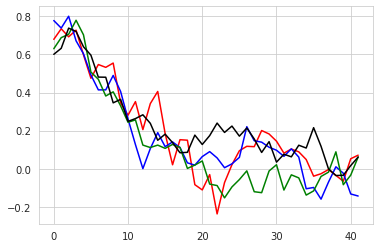

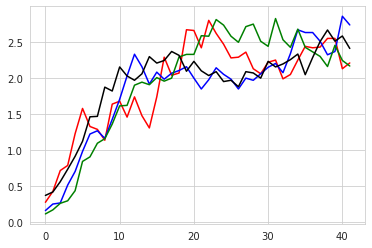

In [262]:
plt.plot(np.array(wr1_acc), c='r'); 
plt.plot(np.array(wr2_acc), c='b'); 
plt.plot(np.array(wr3_acc), c='g'); 
plt.plot(np.array(wr4_acc), c='k'); 
plt.show()

plt.plot(np.array(wr1_mse), c='r'); 
plt.plot(np.array(wr2_mse), c='b'); 
plt.plot(np.array(wr3_mse), c='g'); 
plt.plot(np.array(wr4_mse), c='k'); 
plt.show()

# normalize by sample size